# Cosmographic uncertainty estimation and forecasting

This notebook provides a quick propagation of joint lens model, kinematics, time-delay and line-of-sight uncertainties to jointly and self-consistently propagate to the cosmographic posteriors that then can be used to sample e.g. the Hubble constant.

This notebook can be used to provide realistic forecasts as well as an assessment of current time-delay lenses on their error budget.

The notebook uses *lenstronomy* to perform all the necessary computations and performs the sampling technique used by [Birrer et al. 2016](https://arxiv.org/abs/1511.03662) [Birrer et al. 2019](https://arxiv.org/abs/1809.01274).

In [1]:
# some standard python imports #
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[-144.44102062 -126.498851   -119.82439434 -116.67016627]
longest delay is 27.770854346883766  days between image 3 and image 0


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


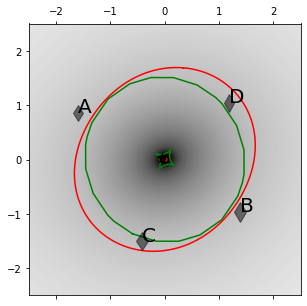

In [2]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# kappa external at the lens LOS that is not accounted for in the lens model
kappa_ext_mean = 0

# lensing quantities
# the lens model is a supperposition of an elliptical lens model with external shear
gamma = 1.98
kwargs_shear = {'gamma1': 0.06, 'gamma2': -0.02}  # shear values to the source plane
kwargs_pemd = {'theta_E': 1.66, 'gamma': gamma, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.05, 'e2': 0.05}  # parameters of the deflector lens model
kwargs_lens = [kwargs_pemd, kwargs_shear]


from lenstronomy.LensModel.lens_model import LensModel
lens_model_list = ['PEMD', 'SHEAR']
lens_model = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source)

# choice of source position
source_x, source_y = -0.05, 0.02

from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lensEquationSolver = LensEquationSolver(lensModel=lens_model)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=0.05, search_window=5)

kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image}]

# compute time delay
dt = lens_model.arrival_time(x_image, y_image, kwargs_lens, kappa_ext=kappa_ext_mean)
print(dt)


# to perform the forecast, we focus on the longest delay
i_A = np.where(dt == np.max(dt))[0][0]
i_B = np.where(dt == np.min(dt))[0][0]
dt_AB = dt[i_A] - dt[i_B]
print('longest delay is', dt_AB, ' days between image', i_A, 'and image', i_B)

# print lens and image positions
from lenstronomy.Plots import lens_plot
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lens_model, kwargs_lens=kwargs_lens, sourcePos_x=source_x, sourcePos_y=source_y, point_source=True, with_caustics=True, fast_caustic=True)
f.show()


# set deflector light profile
lens_light_model_list = ['HERNQUIST']
r_eff = 0.7  # half light radius of the deflector galaxy
kwargs_lens_light = [{'Rs': r_eff * 0.551, 'amp': 1., 'center_x': 0, 'center_y': 0}]

kwargs_model = {'lens_model_list': lens_model_list, 
                'lens_light_model_list': lens_light_model_list, 
                'point_source_model_list': ['LENSED_POSITION'],
                'z_lens': z_lens, 'z_source': z_source}


In [3]:
from lenstronomy.Analysis.kinematics_api import KinematicsAPI

# observational conditions of the spectroscopic campagne
R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7  # Full width at half maximum (FWHM) Point Spread Function (PSF)

aperture_type = 'slit'
kwargs_aperture = {'aperture_type': aperture_type, 'center_ra': 0, 'width': dR_slit, 'length': R_slit, 'angle': 0, 'center_dec': 0}

kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}

anisotropy_model = 'OM'
r_ani = 1.
kwargs_anisotropy = {'r_ani': r_ani}

kwargs_numerics_galkin = { 
                          'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

kinematicsAPI = KinematicsAPI(z_lens, z_source, kwargs_model, kwargs_aperture, kwargs_seeing, anisotropy_model, 
                              kwargs_numerics_galkin=kwargs_numerics_galkin, lens_model_kinematics_bool=[True, False],
                              sampling_number=5000  # numerical ray-shooting, should converge -> infinity
                             )


vel_disp_numerical = kinematicsAPI.velocity_dispersion(kwargs_lens, kwargs_lens_light, kwargs_anisotropy, r_eff=r_eff)
theta_E = kwargs_lens[0]['theta_E']
gamma = kwargs_lens[0]['gamma']
vel_disp_analytic = kinematicsAPI.velocity_dispersion_analytical(theta_E, gamma, r_ani=r_ani, r_eff=r_eff)
print(vel_disp_numerical, vel_disp_analytic, 'velocity dispersion in km/s')

297.0198743261239 296.8529302583581 velocity dispersion in km/s


In [4]:

# initiate solver
from lenstronomy.LensModel.Solver.solver import Solver
solver = Solver(solver_type='PROFILE_SHEAR', lensModel=lens_model, num_images=len(x_image))


class ImageModelUncertainties(object):
    
    def __init__(self, sigma_gamma, sigma_astrometry):
        self._sigma_gamma = sigma_gamma
        self._sigma_astrometry = sigma_astrometry

    def draw_lens(self, kwargs_lens):
        kwargs_lens_draw = copy.deepcopy(kwargs_lens)
        gamma_draw = np.random.normal(loc=gamma, scale=sigma_gamma)
        kwargs_lens_draw[0]['gamma'] = gamma_draw
        return kwargs_lens_draw

    def draw_lens_light(self, kwargs_lens_light):
        kwargs_lens_light_draw = copy.deepcopy(kwargs_lens_light)
        return kwargs_lens_light_draw
    
    def draw_image_positions(self, kwargs_ps):
        kwargs_ps_draw = copy.deepcopy(kwargs_ps)
        delta_x = np.random.normal(loc=0, scale=self._sigma_astrometry, size=len(x_image))
        delta_y = np.random.normal(loc=0, scale=self._sigma_astrometry, size=len(x_image))
        kwargs_ps_draw[0]['ra_image'] += delta_x
        kwargs_ps_draw[0]['dec_image'] += delta_y
        return kwargs_ps_draw
    
    def draw_anisotropy(self):
        r_min = 0.5
        r_max = 5
        r_ani = np.random.uniform(r_min, r_max)
        kwargs_anisotropy_draw = {'r_ani': r_ani}
        return kwargs_anisotropy_draw

    def model_realization(self, kwargs_lens, kwargs_ps, kwargs_lens_light):
        """
        returns kwargs of the different model components
        This routine effectively replaces a sampling method of the model parameters
        """
        kwargs_lens_draw = self.draw_lens(kwargs_lens)
        kwargs_ps_draw = self.draw_image_positions(kwargs_ps)
        kwargs_lens_draw = solver.update_solver(kwargs_lens_draw, kwargs_ps_draw[0]['ra_image'], kwargs_ps_draw[0]['dec_image'])
        kwargs_lens_light_draw = self.draw_lens_light(kwargs_lens_light)
        kwargs_anisotropy_draw = self.draw_anisotropy()
        return kwargs_lens_draw, kwargs_ps_draw, kwargs_lens_light_draw, kwargs_anisotropy_draw
    
class DataUncertainties(object):
    
    def __init__(self, dt_AB, dt_sigma, vel_disp, vel_disp_sigma, kappa_ext_mean, kappa_ext_sigma):
        self._dt_AB = dt_AB
        self._dt_sigma = dt_sigma
        self._vel_disp = vel_disp
        self._vel_disp_sigma = vel_disp_sigma
        self._kappa_ext_mean = kappa_ext_mean
        self._kappa_ext_sigma = kappa_ext_sigma
        
    def draw_dt(self):
        return np.random.normal(loc=self._dt_AB, scale=self._dt_sigma)
    
    def draw_kappa_ext(self):
        return np.random.normal(loc=self._kappa_ext_mean, scale=self._kappa_ext_sigma)
    
    def draw_vel_disp(self):
        return np.random.normal(loc=self._vel_disp, scale=self._vel_disp_sigma)
    


In [5]:
# set uncertainty in lens model
sigma_gamma = 0.05  # 1-sigma uncertainty in the slope of a power-law mass profile

# set uncertainties in image position astrometry
sigma_astrometry = 0.005  # 1-sigma astrometric uncertainties in the image positions in arc seconds

# set uncertainties in time delay
dt_sigma = 1. # 1-sigma uncertainty in the time-delay measurement in the longest delay

# set LOS distribution uncertainty
kappa_ext_sigma = 0.04  # 1-sigma Gaussian uncertainty in the external convergence estimate

# set velocity dispersion uncertainty
vel_disp_sigma = 10. # 1-sigma Gaussia uncertainty [km/s]


from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, lens_model_kinematics_bool=[True, False],
                        kwargs_seeing=kwargs_seeing, kwargs_aperture=kwargs_aperture, anisotropy_model=None)
td_cosmo.kinematics_modeling_settings(anisotropy_model, kwargs_numerics_galkin, analytic_kinematics=True,
                                     Hernquist_approx=False, MGE_light=False, MGE_mass=False)

data_uncertainties = DataUncertainties(dt_AB, dt_sigma, vel_disp_analytic, vel_disp_sigma, kappa_ext_mean, kappa_ext_sigma)
model_uncertainties = ImageModelUncertainties(sigma_gamma, sigma_astrometry)

def draw_model():
    kwargs_lens_draw, kwargs_ps_draw, kwargs_lens_light_draw, kwargs_anisotropy_draw = model_uncertainties.model_realization(kwargs_lens, kwargs_ps, kwargs_lens_light)
    fermat_pot = td_cosmo.fermat_potential(kwargs_lens_draw, kwargs_ps_draw)
    d_fermat_model = fermat_pot[i_A] - fermat_pot[i_B]
    r_eff = kwargs_lens_light_draw[0]['Rs'] / 0.551
    theta_E = kwargs_lens_draw[0]['theta_E']
    gamma = kwargs_lens_draw[0]['gamma']
    J = td_cosmo.velocity_dispersion_dimension_less(kwargs_lens_draw, kwargs_lens_light_draw, kwargs_anisotropy_draw, r_eff=r_eff,
                                           theta_E=theta_E, gamma=gamma)
    return d_fermat_model, J

def draw_distance(d_fermat_model, J):
    dt_measured = data_uncertainties.draw_dt()
    vel_disp_measured = data_uncertainties.draw_vel_disp()
    kappa_s = data_uncertainties.draw_kappa_ext()
    D_dt, D_d = td_cosmo.ddt_dd_from_time_delay_and_kinematics(d_fermat_model, dt_measured, vel_disp_measured, J, kappa_s=kappa_s,
                                              kappa_ds=0, kappa_d=0)
    return D_dt, D_d

def draw_sample(num_model, num_data):
    D_dt_sample = []
    D_d_sample = []
    for i in range(num_model):
        d_fermat_model, J = draw_model()
        for j in range(num_data):
            D_dt_i, D_d_i = draw_distance(d_fermat_model, J)
            D_dt_sample.append(D_dt_i)
            D_d_sample.append(D_d_i)
        if i % 10 == 0:
            print(i)
    return np.array(D_dt_sample), np.array(D_d_sample)

In [6]:
D_dt_sample, D_d_sample = draw_sample(num_model=100, num_data=1000)


0
10
20
30
40
50
60
70
80
90


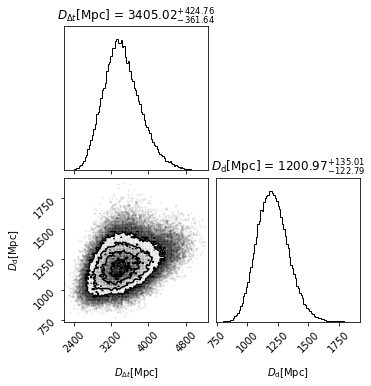

In [7]:
# illustrate distance posteriors
samples_merged = np.zeros((len(D_dt_sample), 2))

D_dt_sample = np.array(D_dt_sample.tolist(), dtype=float)
D_d_sample = np.array(D_d_sample.tolist(), dtype=float)
samples_merged[:, 0] = D_dt_sample
samples_merged[:, 1] = D_d_sample


import corner
corner.corner(samples_merged, show_titles=True, labels=[r'$D_{\Delta t}$[Mpc]', r'$D_{\rm d}$[Mpc]'], bins=100)
plt.show()

## Sampling with $\texttt{hierArc}$
Here we sample the cosmological parameters from the angular diameter distance posteriors with $\texttt{hierArc}$ (https://github.com/sibirrer/hierarc).
More documentation about $\texttt{hierArc}$ can be found there.

  2%|▎         | 5/200 [00:06<04:03,  1.25s/it]/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:45: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)
100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


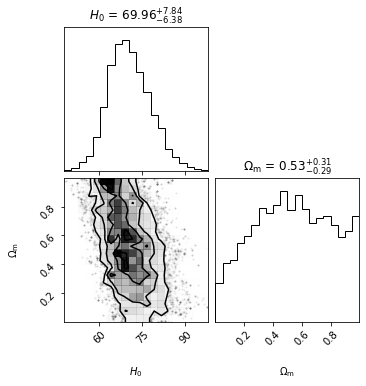

In [8]:
from hierarc.Sampling.mcmc_sampling import MCMCSampler


bandwidth = 2
kde_type = 'scipy_gaussian'  # 'gaussian', 'epanechnikov', 'scipy_gaussian'

# here you can add as many lenses as you want to jointly sample from
kwargs_lens_list = [{'z_lens': z_lens, 'z_source': z_source, 
                     'likelihood_type': 'DdtDdKDE', 'dd_samples': D_d_sample,
                       'ddt_samples': D_dt_sample, 'kde_type': kde_type, 'bandwidth': bandwidth}]

cosmology = 'FLCDM'

n_walkers = 100
n_run = 100
n_burn = 100

kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {},
                     'kwargs_kin': {}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.1},
                     'kwargs_lens': {},
                     'kwargs_kin': {}}


kwargs_bounds = {'kwargs_lower_cosmo': {'h0': 1, 'om': 0},
                'kwargs_lower_lens': {},
                'kwargs_lower_kin': {},
                'kwargs_upper_cosmo': {'h0': 200, 'om': 1},
                'kwargs_upper_lens': {},
                'kwargs_upper_kin': {},
                'kwargs_fixed_cosmo': {},
                'kwargs_fixed_lens': {},
                'kwargs_fixed_kin': {}}

mcmc_sampler = MCMCSampler(kwargs_lens_list, cosmology, kwargs_bounds)
mcmc_samples, log_prob_cosmo = mcmc_sampler.mcmc_emcee(n_walkers, n_run, n_burn, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples, show_titles=True, labels=mcmc_sampler.param_names(latex_style=True))
plt.show()